In [1]:
import pathlib
import scipy.constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fytok.Tokamak import Tokamak
from fytok.modules.CoreProfiles import CoreProfiles
from fytok.modules.Equilibrium import Equilibrium
from spdm.view import View as sp_view
from spdm.core.Path import Path
from spdm.core.Function import Function
from spdm.core.Expression import Variable

2024-02-10 12:30:45,443 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev102+gfad9d5c.d20240126, imas_version=v3_38_1_dirty)

 Run by salmon at 2024-02-10T12:30:45.246874.
 Job ID: fytok_salmon_surface_2286

###################################################################################################



## 导入基准数据


In [2]:
data_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

astra_profiles = pd.read_excel(
    next(data_path.glob("*ASTRA.xls")).absolute().as_posix(), sheet_name=1, header=10, usecols="B:BN"
)
astra_rho_tor_norm = astra_profiles["x"].values

core_profiles_astra = CoreProfiles(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}#core_profiles"
)

core_profiles_1d_astra = core_profiles_astra.time_slice.current.profiles_1d

equilibrium_astra = Equilibrium(f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}#equilibrium")

2024-02-10 12:30:45,925 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2024-02-10 12:30:46,050 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-02-10 12:30:46,166 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2024-02-10 12:30:46,170 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk
2024-02-10 12:30:46,221 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 


## 初始化 Tokamak


In [3]:
tokamak = Tokamak(
    device="iter",
    shot=900003,
    equilibrium=f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}#equilibrium",
    # core_profiles=f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}#core_profiles",
    core_transport={
        "model": [
            {"code": {"name": "predefined"}},
            {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}#core_sources/source/0",
            {"code": {"name": "collisional_equipartition"}},
            {"code": {"name": "fusion", "parameters": {"fusion_reactions": ["D(t,n)alpha"], "heating": True}}},
            # {"code": {"name": "radiation"}},
            # {"code": {"name": "synchrotron_radiation"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "discontinuity": [0.96, 0.995],
                "dc_pos": 0.96,
                "hyper_diff": 1.0e-5,
                "max_nodes": 512,
                "bc_tol": 1,
                "verbose": 2,
                "units": {
                    "psi_norm": 1,
                    "psi_norm_flux": -0.1,
                    "*/density": 1.0e19,
                    "*/density_flux": 1.0e23,
                    "*/temperature": 1.0e4,
                    "*/temperature_flux": 1.0e26,
                    # "ion/alpha/density": 1.0e14,
                    # "ion/alpha/density_flux": 1.0e16,
                    # "ion/He/density": 1.0e15,
                    # "ion/He/density_flux": 1.0e15,
                },
            },
        },
        "ion_thermal": ["D", "T"],  #
        "ion_non_thermal": ["alpha", "He"],
        "impurities": ["Ar", "Be"],
        "boundary_condition_type": {
            # fmt: off
            # psi                          at axis \frac{d\psi}{dx}=0  , at boundary \psi=?
            "psi"                       : 1, 
            "psi_norm"                  : 1, 
            # density                      at axis \Gamma_s=0          , at boundary n=?
            "*/density"                 : 1, 
            # temperatur                   at axis \frac{dT}{dx}=0     , at boundary T=?
            "*/temperature"             : 1,
            # fmt: on
        },
    },
)

2024-02-10 12:30:46,332 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml


In [4]:
tokamak.initialize()

2024-02-10 12:30:46,382 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-02-10 12:30:46,441 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 
2024-02-10 12:30:46,461 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2024-02-10 12:30:46,470 [    spdm]     INFO: Initialize module fytok.modules.TF 
2024-02-10 12:30:46,486 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2024-02-10 12:30:46,497 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2024-02-10 12:30:46,516 [    spdm]     INFO: Initialize module fytok.modules.CoreSources 
2024-02-10 12:30:46,594 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.dummy 
2024-02-10 12:30:46,610 [    spdm]     INFO: Load module fytok.plugins.core_sources.source.collisional_equipartition
2024-02-10 12:30:46,614 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.collisional_equipartition 
2024-02-10 12:30:46,632 [    spdm

In [5]:
tokamak.equilibrium.refresh()
tokamak.core_profiles.refresh()
tokamak.core_sources.refresh()
tokamak.core_transport.refresh()

2024-02-10 12:30:46,790 [    spdm]     INFO: Refresh module fytok.plugins.equilibrium.FyEqAnalyze
2024-02-10 12:30:46,794 [    spdm]     INFO: Refresh module fytok.modules.CoreProfiles
2024-02-10 12:30:46,808 [    spdm]     INFO: Load module spdm.mesh.mesh_rectangular
2024-02-10 12:30:47,552 [    spdm]     INFO: Refresh module fytok.modules.CoreSources
2024-02-10 12:30:47,554 [    spdm]     INFO: Refresh module fytok.plugins.core_sources.source.dummy
2024-02-10 12:30:47,559 [    spdm]     INFO: Refresh module fytok.plugins.core_sources.source.collisional_equipartition
2024-02-10 12:30:47,565 [    spdm]     INFO: Refresh module fytok.plugins.core_sources.source.fusion
2024-02-10 12:30:47,570 [    spdm]     INFO: Refresh module fytok.modules.CoreTransport
2024-02-10 12:30:47,572 [    spdm]     INFO: Refresh module fytok.plugins.core_transport.model.predefined
2024-02-10 12:30:47,578 [    spdm]     INFO: Refresh module fytok.plugins.core_transport.model.fast_alpha


## 检查系数


### 源项 predefined


2024-02-10 12:30:47,688 [    spdm]     INFO: Load module spdm.view.view_matplotlib


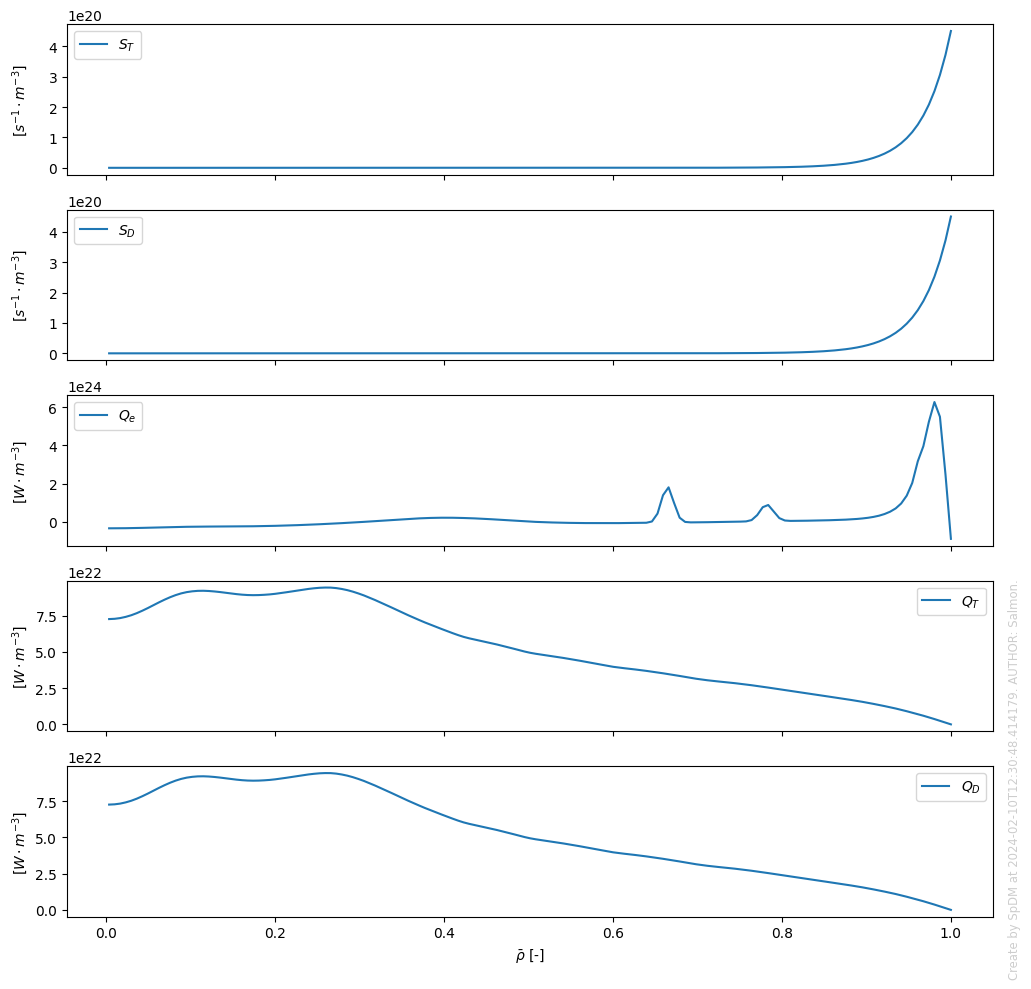

In [6]:
source_1d = tokamak.core_sources.source[0].fetch(core_profiles_1d_astra).profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    *[(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    *[(source_1d.electrons.energy, r"$Q_{e}$")] + [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=10,
)

### 源项 碰撞热交换


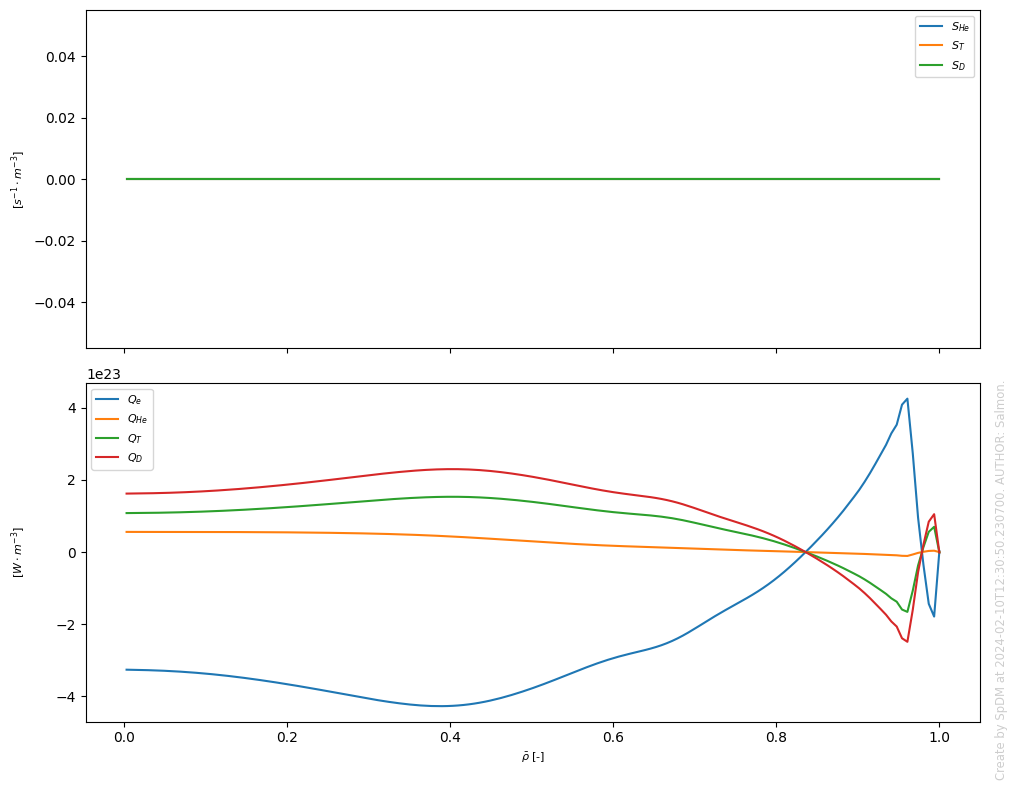

In [7]:
source_1d = tokamak.core_sources.source[1].fetch(core_profiles_1d_astra).profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")] + [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=8,
)

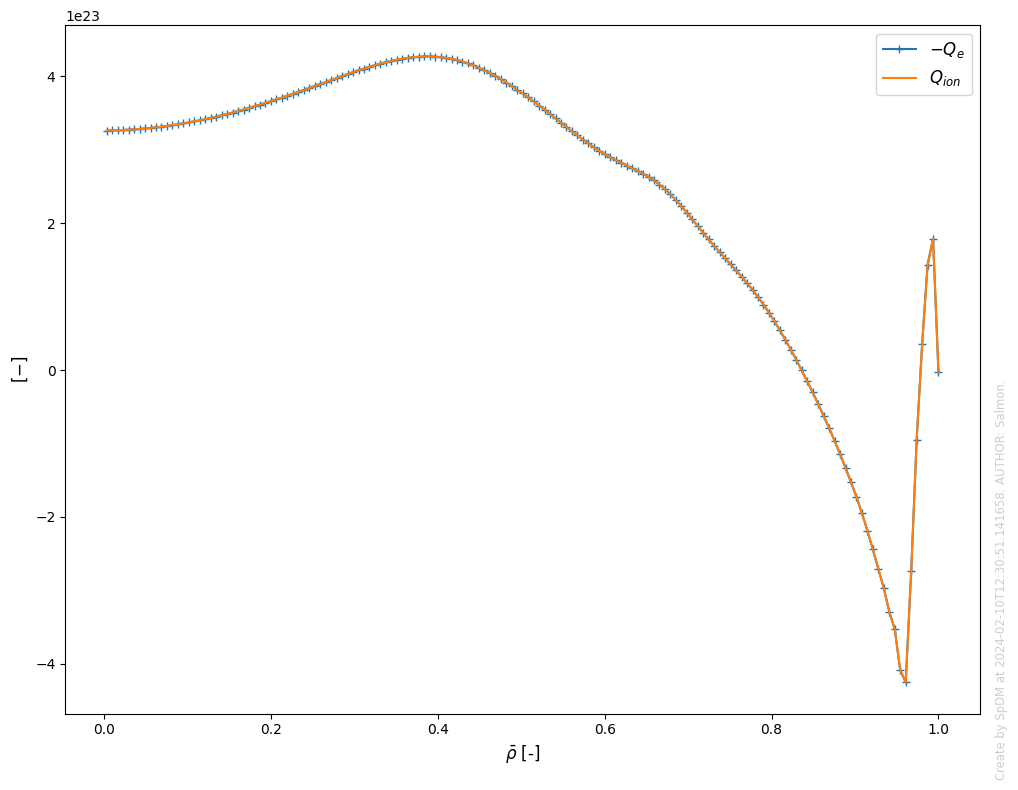

In [8]:
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [
        (-source_1d.electrons.energy, {"label": r"$-Q_{e}$", "$matplotlib": {"marker": "+"}}),
        (sum([ion.energy for ion in source_1d.ion], 0), r"$Q_{ion}$"),
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [9]:
fig.get_size_inches()

array([10.,  8.])

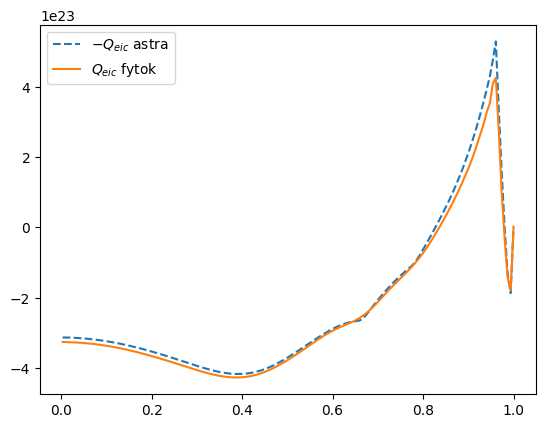

In [10]:
plt.plot(
    astra_rho_tor_norm,
    -astra_profiles["Peic"].values * 1.0e6 / scipy.constants.electron_volt,
    "--",
    label=r"$-Q_{eic}$ astra",
    
)
plt.plot(source_1d.grid.rho_tor_norm, source_1d.electrons.energy(source_1d.grid.rho_tor_norm), label=r"$Q_{eic}$ fytok")
plt.legend()

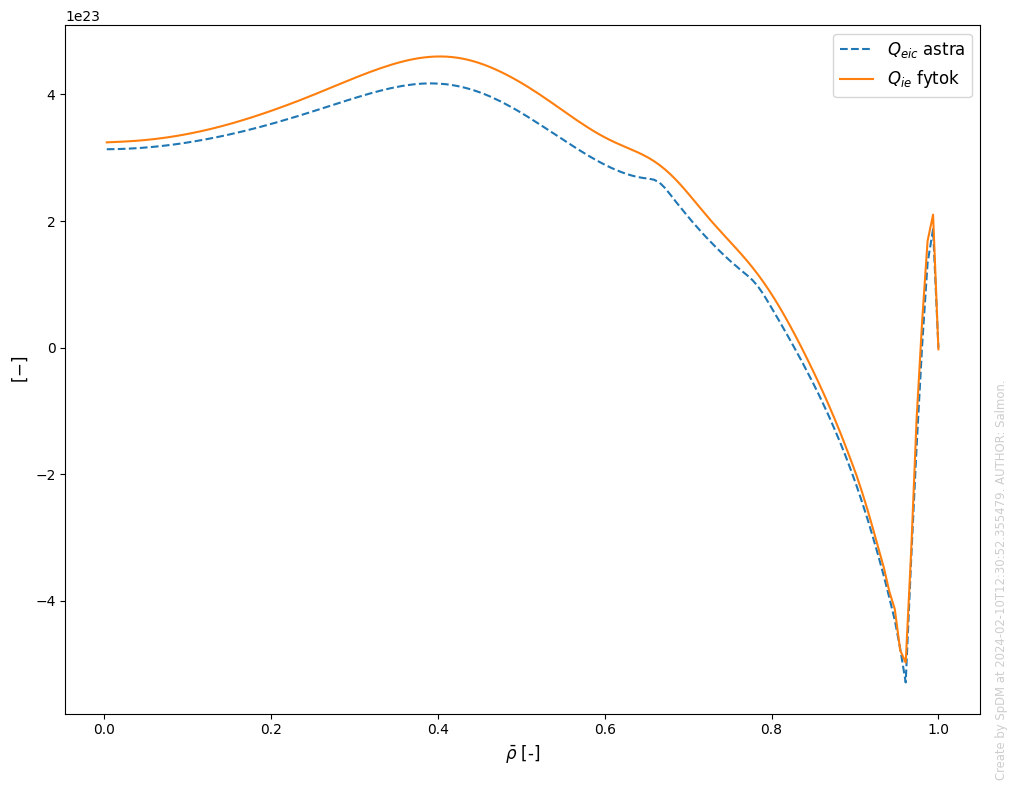

In [11]:
fig=sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [
        (
            (astra_rho_tor_norm, astra_profiles["Peic"].values * 1.0e6 / scipy.constants.electron_volt),
            {"label": r"$Q_{eic}$ astra", "$matplotlib": {"linestyle": "--"}},
        ),
        (source_1d.ion["D"].energy * 2, r"$Q_{ie}$ fytok"),
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

### 源项 Fusion


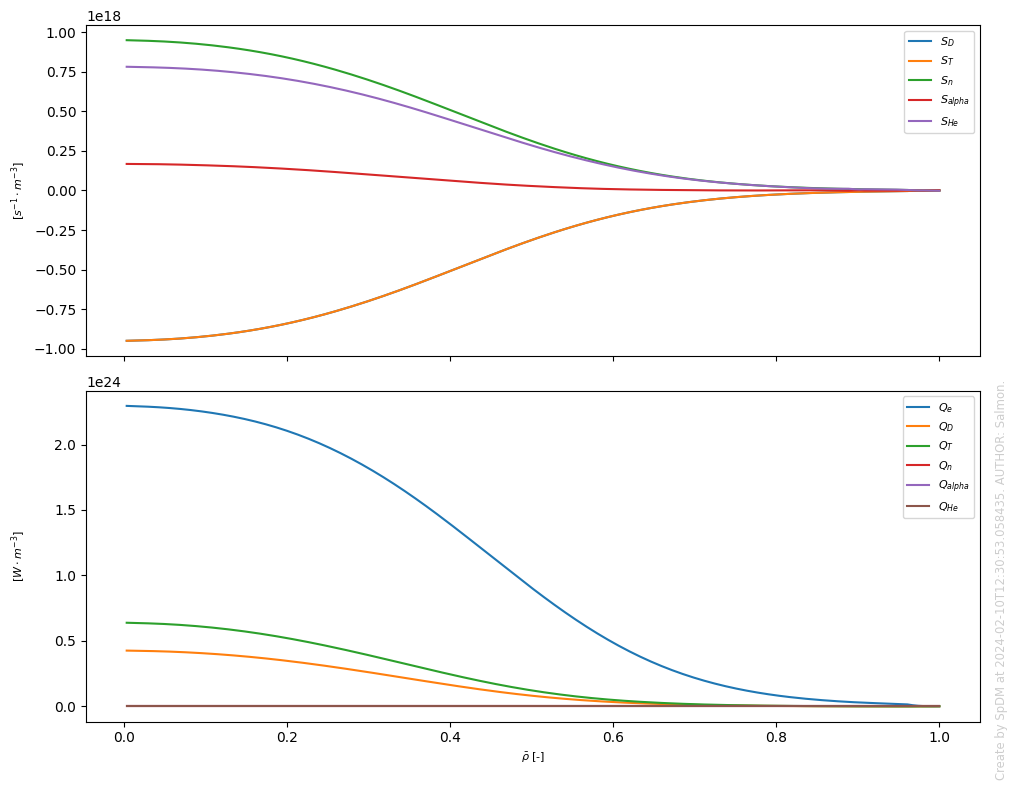

In [12]:
source_1d = tokamak.core_sources.source[2].fetch(core_profiles_1d_astra).profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")] + [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=8,
)

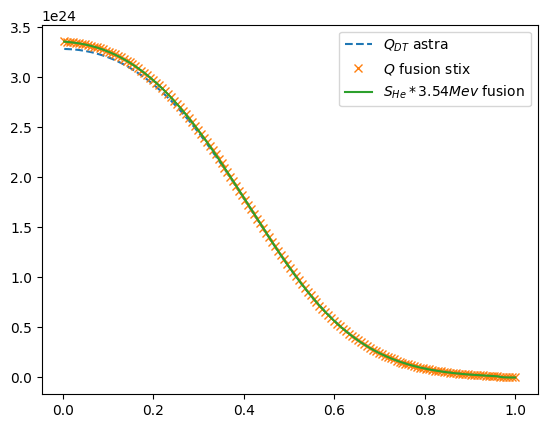

In [13]:
plt.plot(
    astra_rho_tor_norm,
    astra_profiles["Pdt"].values * 1.0e6 / scipy.constants.electron_volt,
    "--",
    label=r"$Q_{DT}$ astra",
)


plt.plot(
    source_1d.grid.rho_tor_norm,
    source_1d.electrons.energy(source_1d.grid.rho_tor_norm)
    + source_1d.ion["D"].energy(source_1d.grid.rho_tor_norm)
    + source_1d.ion["T"].energy(source_1d.grid.rho_tor_norm),
    "x",
    label="$Q$ fusion stix",
)

plt.plot(
    source_1d.grid.rho_tor_norm,
    (
        source_1d.ion["alpha"].particles(source_1d.grid.rho_tor_norm)
        + source_1d.ion["He"].particles(source_1d.grid.rho_tor_norm)
    )
    * (3.54e6),
    label="$S_{He}* 3.54Mev$ fusion",
)

plt.legend()

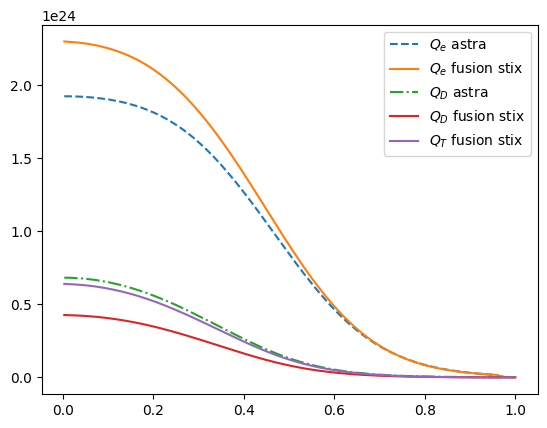

In [14]:
plt.plot(
    astra_rho_tor_norm,
    astra_profiles["Pdte"].values * 1.0e6 / scipy.constants.electron_volt,
    "--",
    label=r"$Q_e$ astra",
)
plt.plot(
    source_1d.grid.rho_tor_norm,
    source_1d.electrons.energy(source_1d.grid.rho_tor_norm),
    label="$Q_e$ fusion stix ",
)

plt.plot(
    astra_rho_tor_norm,
    astra_profiles["Pdti"].values / 2 * 1.0e6 / scipy.constants.electron_volt,
    "-.",
    label=r"$Q_D$ astra",
)
plt.plot(
    source_1d.grid.rho_tor_norm,
    source_1d.ion["D"].energy(source_1d.grid.rho_tor_norm),
    label="$Q_D$ fusion stix ",
)
plt.plot(
    source_1d.grid.rho_tor_norm,
    source_1d.ion["T"].energy(source_1d.grid.rho_tor_norm),
    label="$Q_T$ fusion stix ",
)
plt.legend()

### 输运系数 Predefined


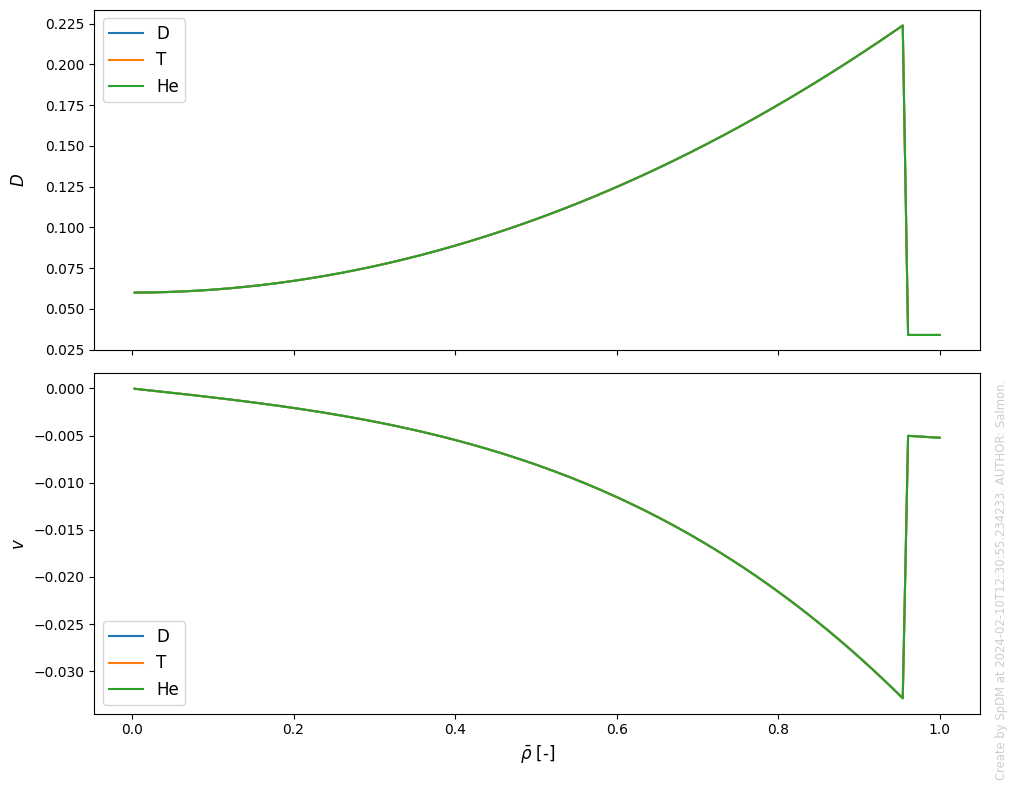

In [15]:
trans_1d = tokamak.core_transport.model[0].fetch(core_profiles_1d_astra).profiles_1d
trans_1d.grid_d = core_profiles_1d_astra.grid
fig = sp_view.plot(
    trans_1d.grid_d.rho_tor_norm,
    ([(ion.particles.d, ion.label) for ion in trans_1d.ion], {"y_label": "D"}),
    ([(ion.particles.v, ion.label) for ion in trans_1d.ion], {"y_label": "v"}),
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [16]:
trans_1d = tokamak.core_transport.model[1].fetch(core_profiles_1d_astra).profiles_1d
trans_1d.grid_d = core_profiles_1d_astra.grid
ion = trans_1d.ion["alpha"]


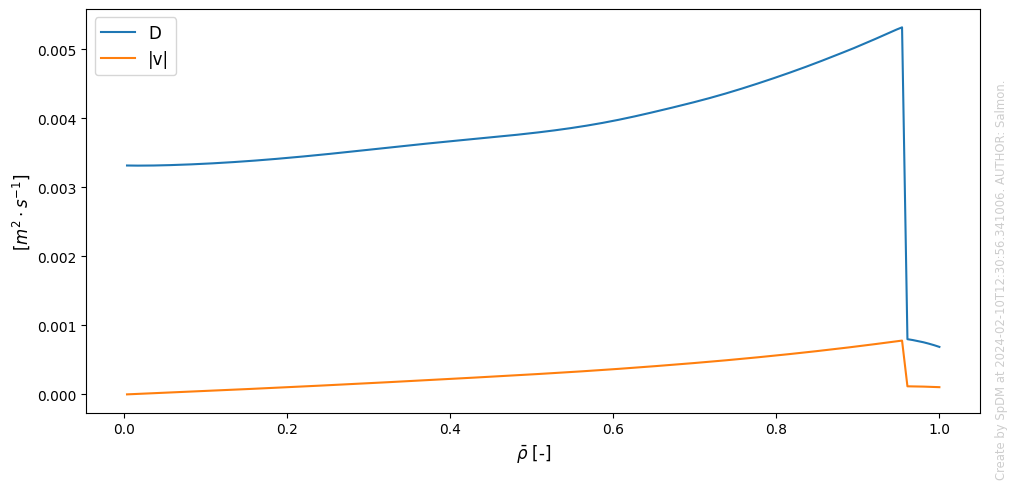

In [17]:
fig = sp_view.plot(
    trans_1d.grid_d.rho_tor_norm,
    [
        (ion.particles.d, "D"),
        (-ion.particles.v, r"|v|"),
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
    height=5,
)

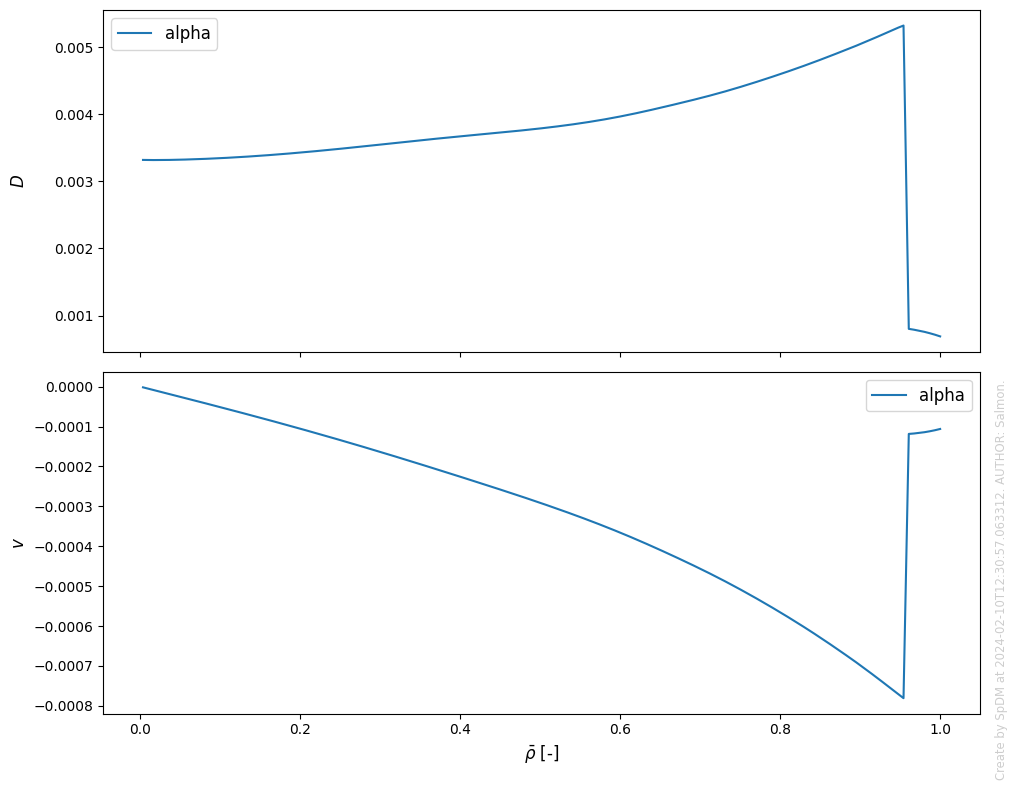

In [18]:
trans_1d = tokamak.core_transport.model[1].fetch(core_profiles_1d_astra).profiles_1d
trans_1d.grid_d = core_profiles_1d_astra.grid
fig = sp_view.plot(
    trans_1d.grid_d.rho_tor_norm,
    ([(ion.particles.d, ion.label) for ion in trans_1d.ion], {"y_label": "D"}),
    ([(ion.particles.v, ion.label) for ion in trans_1d.ion], {"y_label": "v"}),
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [19]:
trans_1d.ion["alpha"].particles.d

{{{{0.02} + {{4.5} \cdot {\frac{temperature}{3500000.0}}}} + {{8.0} \cdot {{\frac{temperature}{3500000.0}} ^ {2}}}} + {{350} \cdot {{\frac{temperature}{3500000.0}} ^ {3}}}} \cdot {d}

## 求解


In [20]:
solver = tokamak.transport_solver
rho_tor_norm_bdry=0.995
rho_tor_norm = np.linspace(0.001,rho_tor_norm_bdry, 128)
eq_grid = tokamak.equilibrium.time_slice.current.profiles_1d.grid.remesh(rho_tor_norm)
psi_norm = eq_grid.psi_norm

In [21]:
F = (1 - rho_tor_norm**2) ** 2
n =3e19 -tokamak.core_sources.source[0].fetch(core_profiles_1d_astra).profiles_1d.ion["D"].particles.I(rho_tor_norm)


In [22]:
solver_1d = solver.preprocess(
    time=0.0,
    rho_tor_norm=rho_tor_norm,
    impurity_fraction=0.02 * 4 + 0.0012 * 18,
    # fmt:off
    initial_value={
        "psi":                              0.0,
        "psi_norm":                         psi_norm,
        "ion/D/density":                    n,          # 5.0e19*Fn , #core_profiles_1d_astra.ion["D"].density(rho_tor_norm) ,# 1.0e19,  #
        "ion/T/density":                    n,          # 5.0e19*Fn , #core_profiles_1d_astra.ion["T"].density(rho_tor_norm) ,# 1.0e19,  #
        "ion/He/density":                   2.0e19*F,   # core_profiles_1d_astra.ion["He"].density(rho_tor_norm)   ,#    
        "ion/alpha/density":                1.0e18*F,   #core_profiles_1d_astra.ion["alpha"].density(rho_tor_norm) ,# 
        
        "ion/D/temperature":                3.5e4*F, # core_profiles_1d_astra.ion["D"].temperature(rho_tor_norm) *0.5,# 
        "ion/T/temperature":                3.5e4*F, # core_profiles_1d_astra.ion["T"].temperature(rho_tor_norm) *0.5,# 
        "electrons/temperature":            3.5e4*F, #core_profiles_1d_astra.electrons.temperature(rho_tor_norm),# 
    },
    # boundary_value={
    #     "ion/D/density":                    n[-1],   # core_profiles_1d_astra.ion["D"].density (rho_tor_norm[-1])    ,
    #     "ion/T/density":                    n[-1],   # core_profiles_1d_astra.ion["T"].density (rho_tor_norm[-1])    ,
    #     "ion/He/density":                   1.0e19*F[-1],
    #     "ion/alpha/density":                1.0e18*F[-1],
    #     "ion/D/temperature":                4.0e4*F[-1] , # core_profiles_1d_astra.ion["D"].temperature (rho_tor_norm[-1]) ,  # 2000,
    #     "ion/T/temperature":                4.0e4*F[-1] , # core_profiles_1d_astra.ion["T"].temperature (rho_tor_norm[-1]) ,  # 2000,
    #     "electrons/temperature":            4.0e4*F[-1] , # core_profiles_1d_astra.electrons.temperature(rho_tor_norm[-1]),   # 2000,
    # },
    # fmt:on
)

### 检查初值

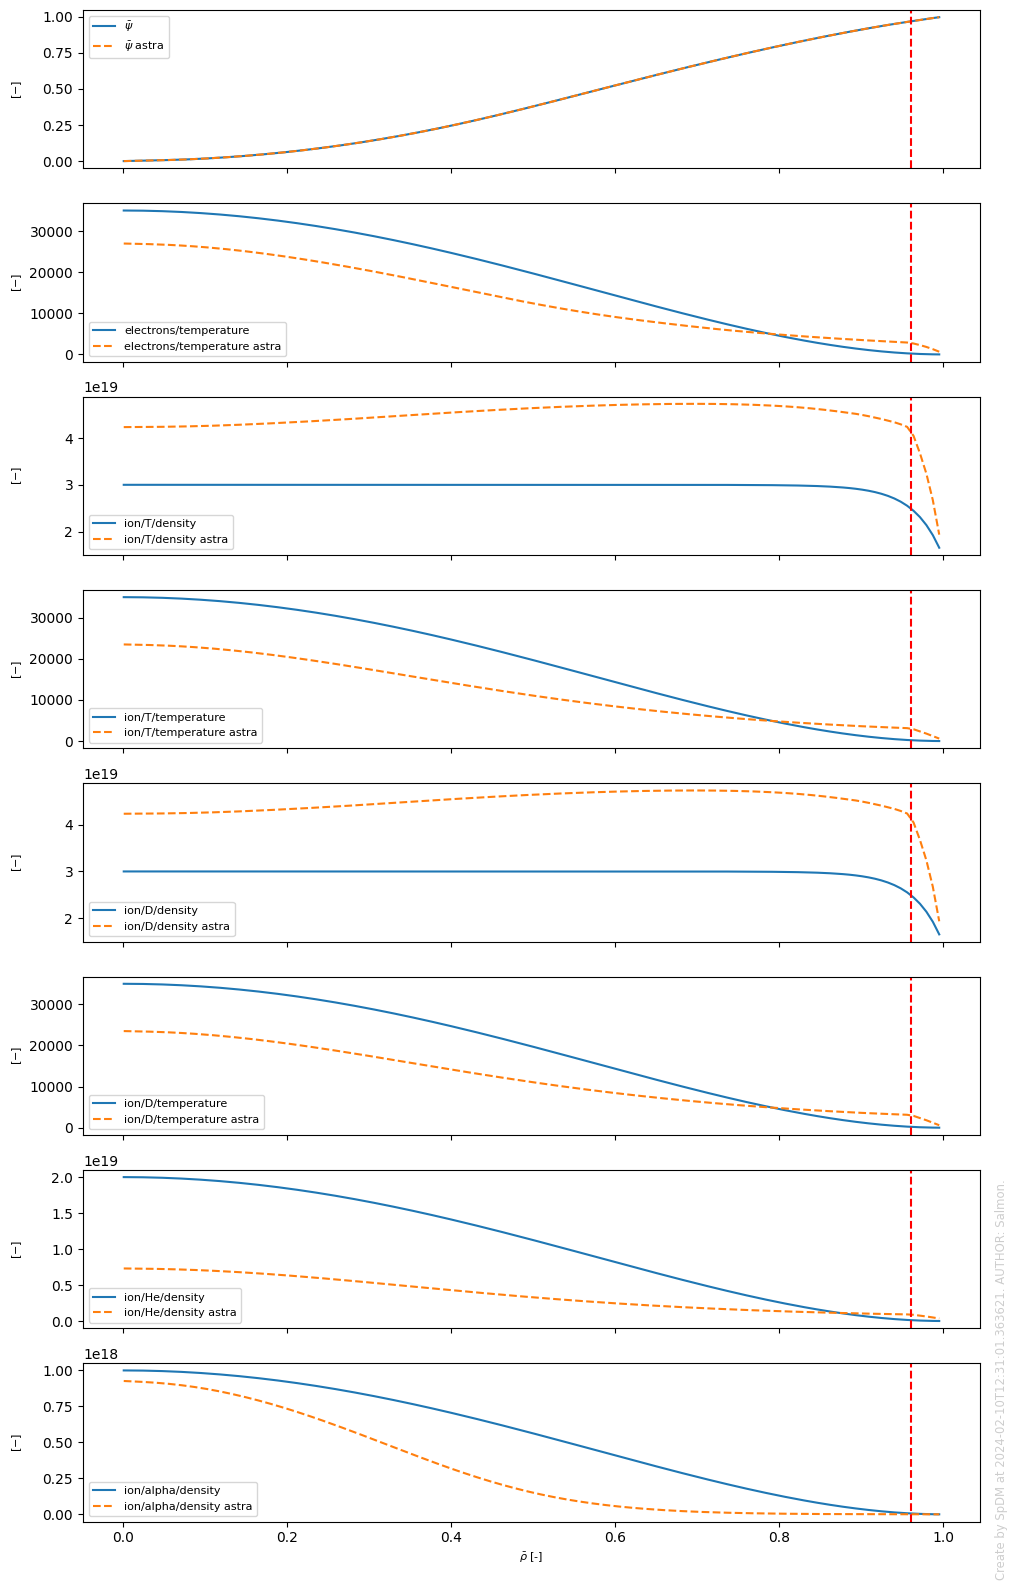

In [23]:
fig = sp_view.plot(
    solver_1d.X,
    [
        (solver_1d.Y[0] * solver._units[0], r"$\bar{\psi}$"),
        (
            Function(
                equilibrium_astra.time_slice.current.profiles_1d.grid.rho_tor_norm,
                equilibrium_astra.time_slice.current.profiles_1d.grid.psi_norm,
            ),
            {"label": r"$\bar{\psi}$ astra", "$matplotlib": {"linestyle": "dashed"}},
        ),
    ],
    *[
        [
            (solver_1d.Y[idx * 2] * solver._units[idx * 2], equ.identifier),
            (
                Path(equ.identifier).get(core_profiles_1d_astra),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for idx, equ in enumerate(solver.equations)
        if equ.identifier != "psi_norm"
    ],
    vline={"x": 0.96, "color": "r", "linestyle": "--"},
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=8,
)

### 计算

In [24]:
solver_1d = solver.execute(solver_1d)

2024-02-10 12:31:04,580 [    spdm]     INFO: Solve transport equations : psi_norm  ,electrons/temperature  ,ion/T/density  ,ion/T/temperature  ,ion/D/density  ,ion/D/temperature  ,ion/He/density  ,ion/alpha/density
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.97e-02       3.36e-16          128            24       
       2          5.40e-03       3.36e-16          152            15       
       3          9.68e-04       3.36e-16          167             0       
Solved in 3 iterations, number of nodes 167. 
Maximum relative residual: 9.68e-04 
Maximum boundary residual: 3.36e-16
2024-02-10 12:31:11,472 [    spdm]     INFO: Solving the transport equation [success]: The algorithm converged to the desired accuracy. , 3 iterations


In [25]:
solver_1d = solver.postprocess(solver_1d)

### 检查结果


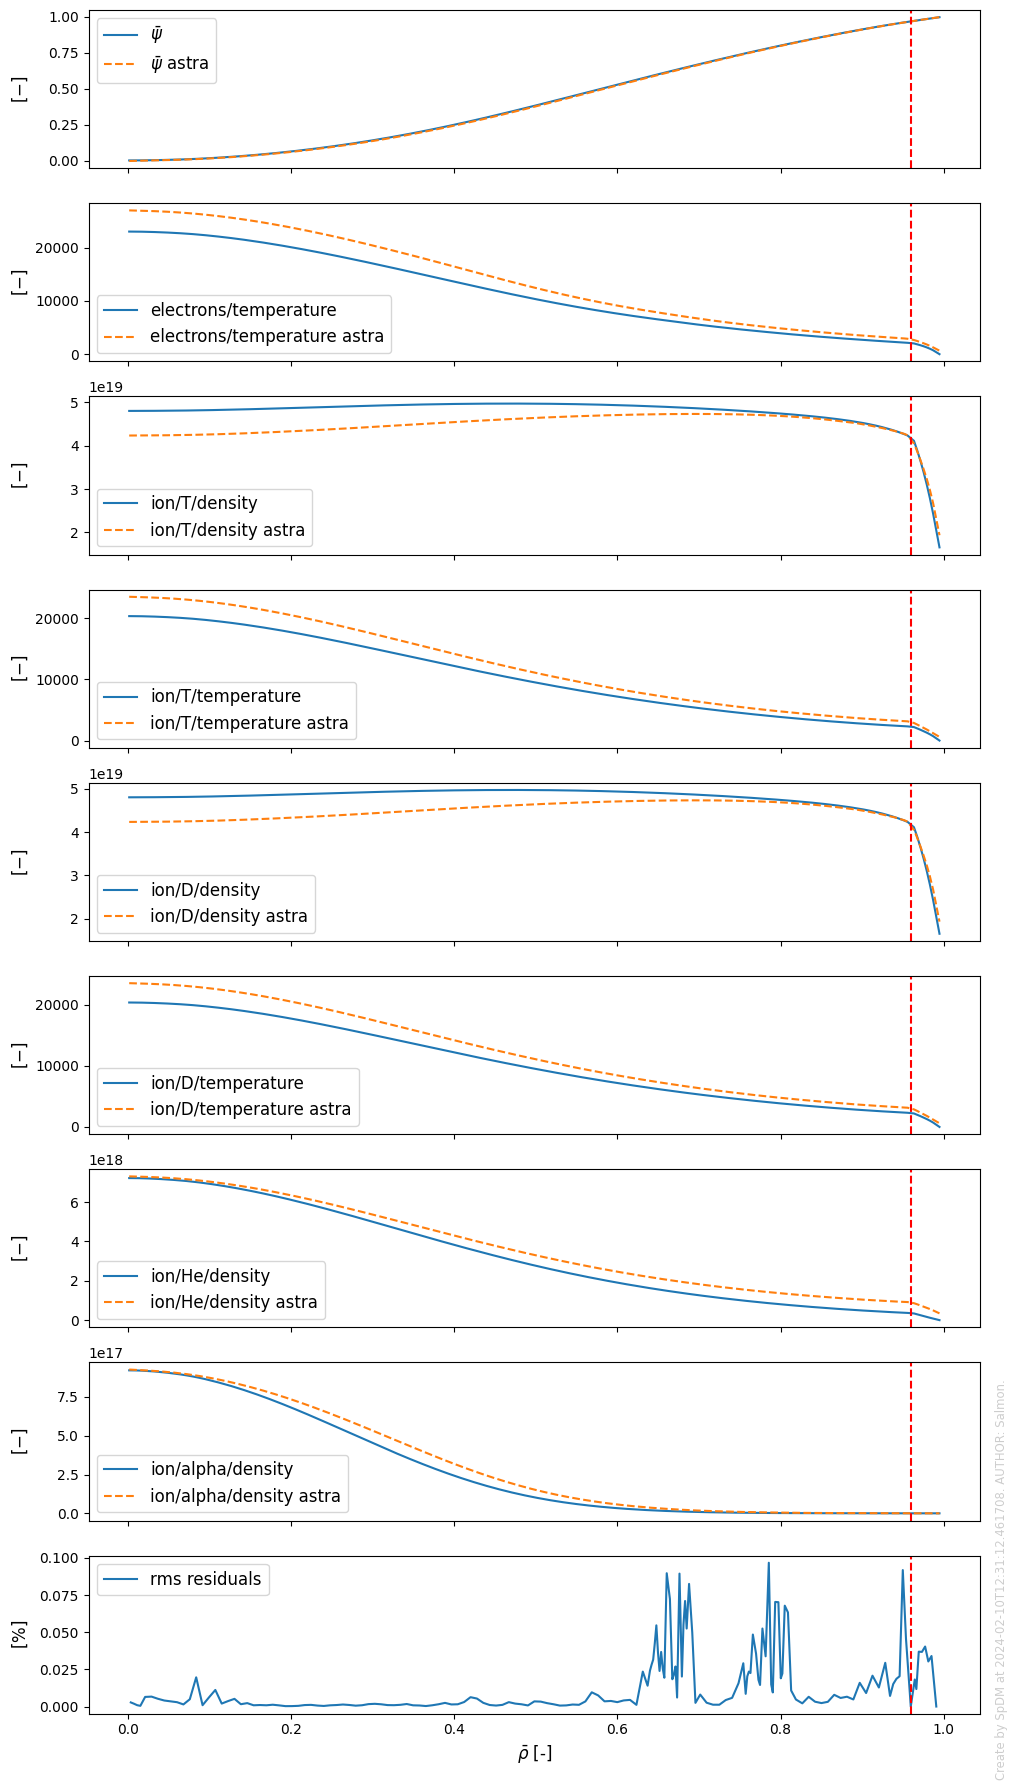

In [26]:
fig = sp_view.plot(
    solver_1d.X,
    [
        (solver_1d.Y[0] * solver._units[0], r"$\bar{\psi}$"),
        (
            Function(
                equilibrium_astra.time_slice.current.profiles_1d.grid.rho_tor_norm,
                equilibrium_astra.time_slice.current.profiles_1d.grid.psi_norm,
            ),
            {"label": r"$\bar{\psi}$ astra", "$matplotlib": {"linestyle": "dashed"}},
        ),
    ],
    *[
        [
            (solver_1d.Y[idx * 2] * solver._units[idx * 2], equ.identifier),
            (
                Path(equ.identifier).get(core_profiles_1d_astra),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for idx, equ in enumerate(solver.equations)
        if equ.identifier != "psi_norm"
    ],
    (
        (0.5 * (solver_1d.X[:-1] + solver_1d.X[1:]), solver_1d.rms_residuals * 100),
        {"label": "rms residuals", "y_label": r"[\%]"},
    ),
    vline={"x": 0.96, "color": "r", "linestyle": "--"},
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

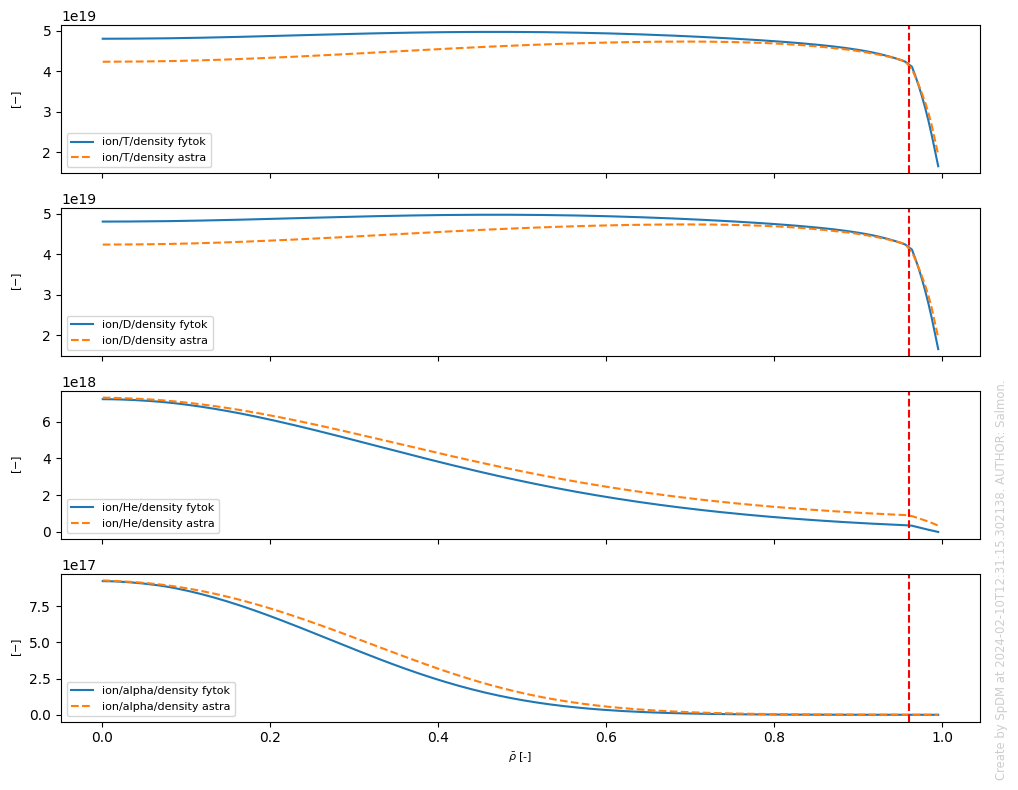

In [27]:
fig = sp_view.plot(
    solver_1d.X,
    *[
        [
            (solver_1d.Y[idx * 2] * solver._units[idx * 2], f"{equ.identifier} fytok"),
            (
                Path(equ.identifier).get(core_profiles_1d_astra, 0),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for idx, equ in enumerate(solver.equations)
        if equ.identifier.endswith("density")
    ],
    vline={"x": 0.96, "color": "r", "linestyle": "--"},
    fontsize=8,
    x_label=r"$\bar{\rho}$ [-]",
)

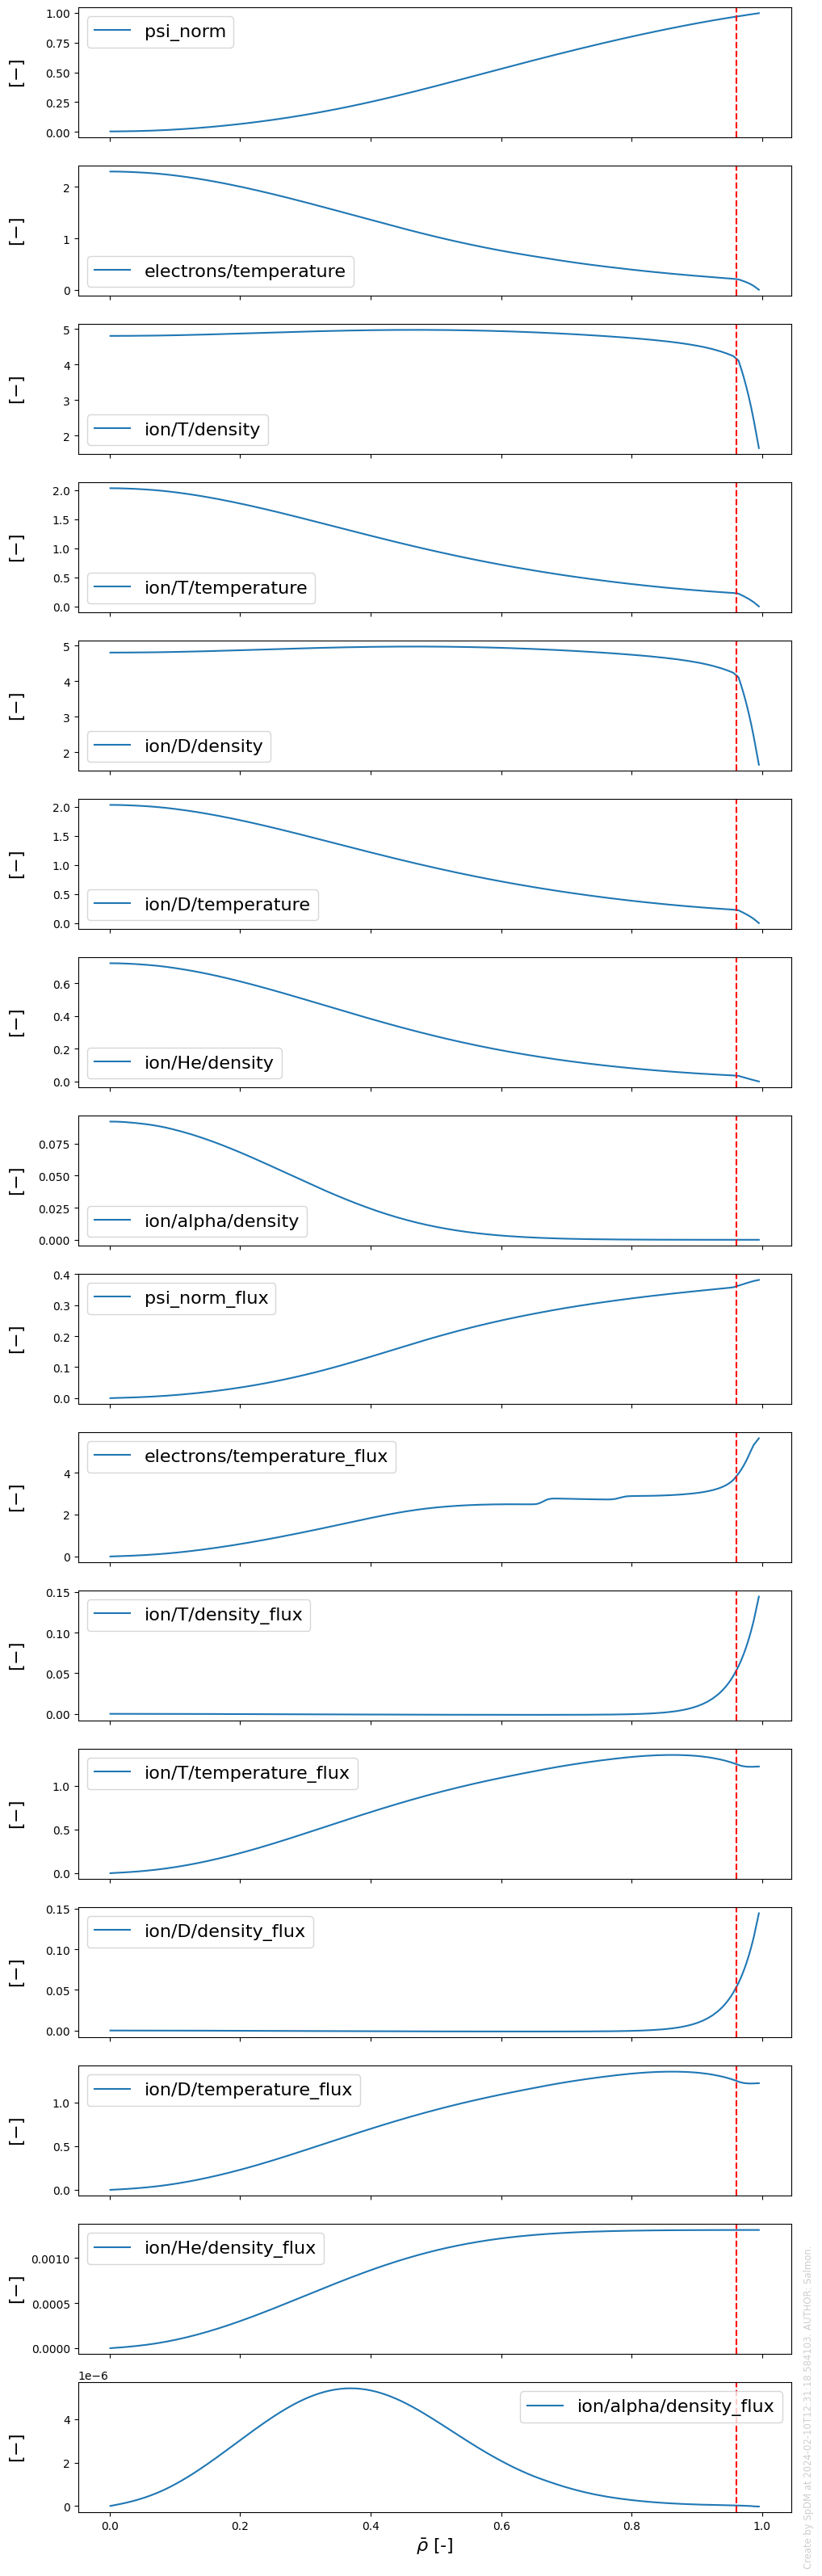

In [28]:
fig = sp_view.plot(
    solver_1d.X,
    *[(solver_1d.Y[idx * 2], equ.identifier) for idx, equ in enumerate(solver.equations)],
    *[(solver_1d.Y[idx * 2 + 1], f"{equ.identifier}_flux") for idx, equ in enumerate(solver.equations)],
    vline={"x": 0.96, "color": "r", "linestyle": "--"},
    x_label=r"$\bar{\rho}$ [-]",
)

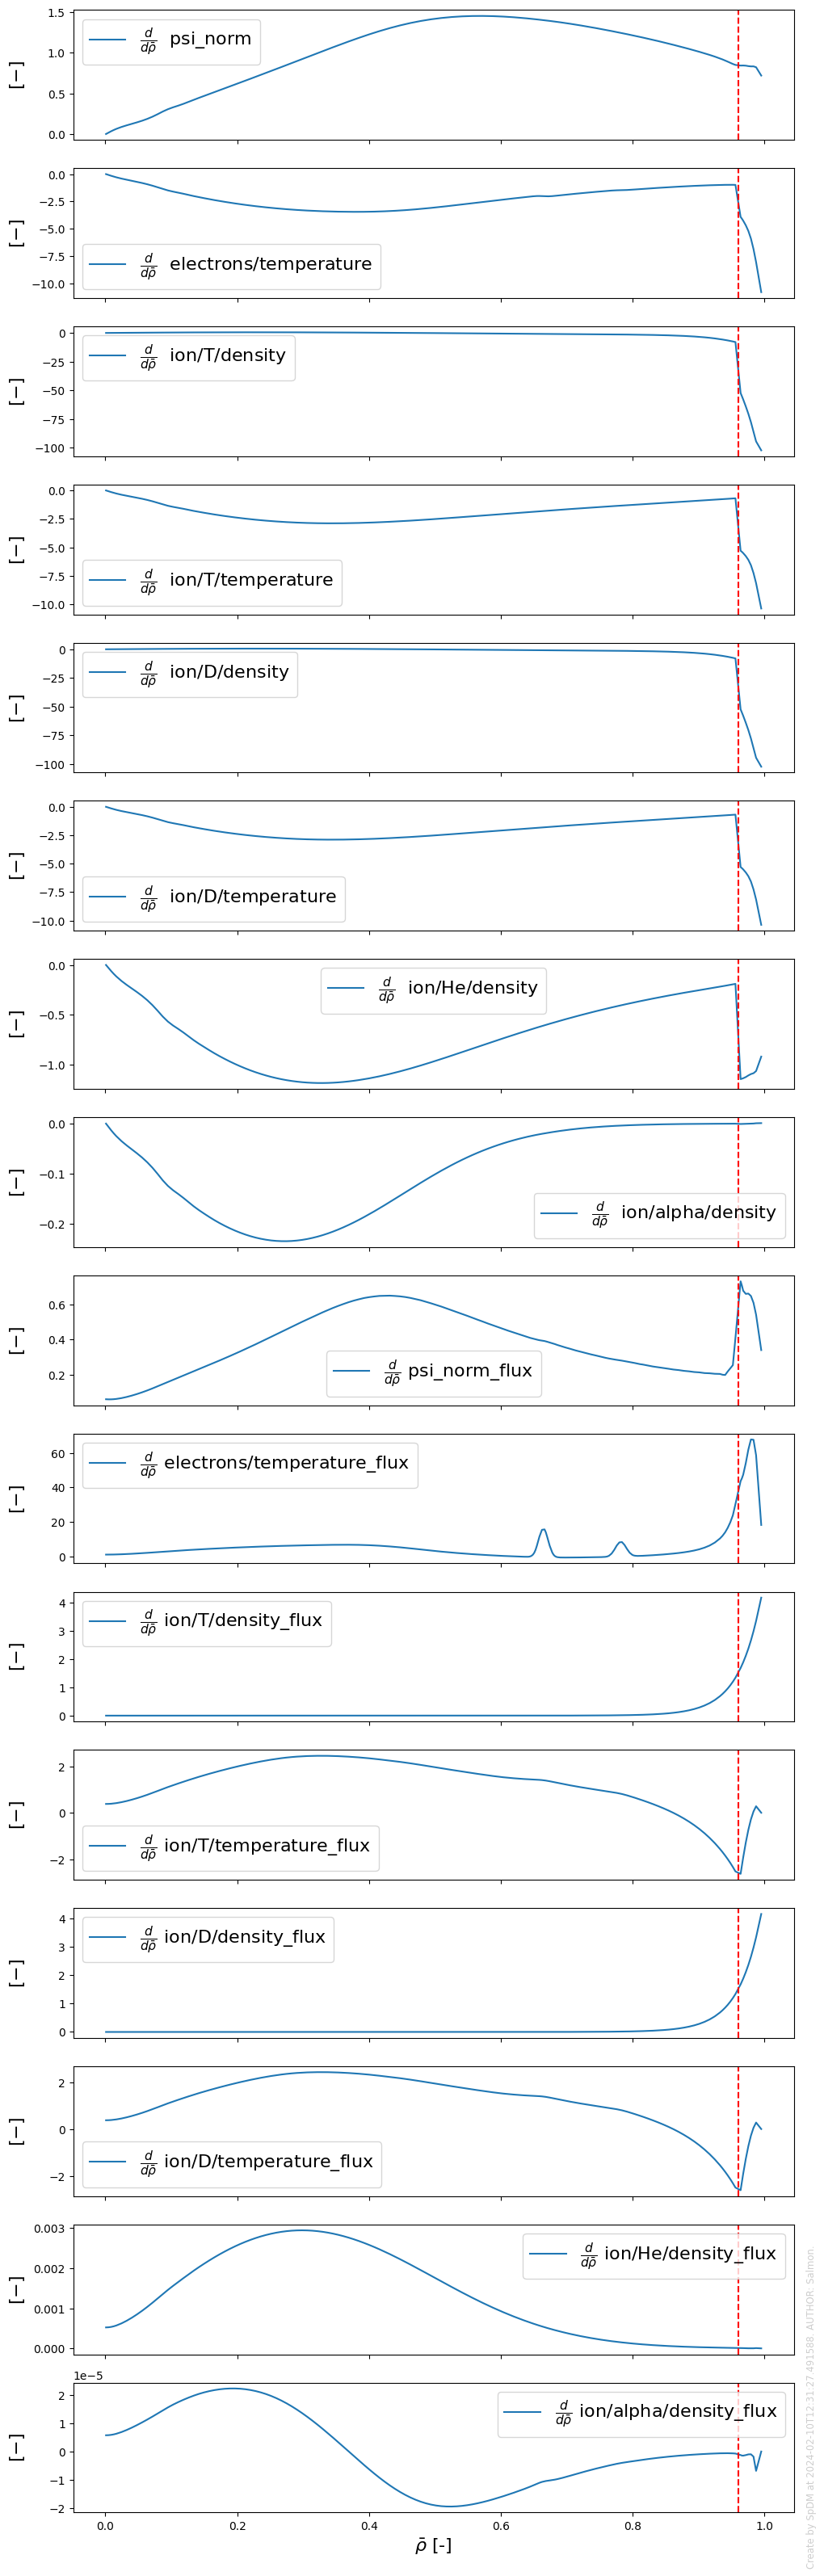

In [29]:
fig = sp_view.plot(
    solver_1d.X,
    *[
        (solver_1d.Yp[idx * 2], rf"$\frac{{d }}{{d\bar{{\rho}}}}$  {equ.identifier} ")
        for idx, equ in enumerate(solver.equations)
    ],
    *[
        (
            solver_1d.Yp[idx * 2 + 1],
            rf"$\frac{{d}}{{d\bar{{\rho}}}}$ {equ.identifier}_flux ",
        )
        for idx, equ in enumerate(solver.equations)
    ],
    vline={"x": 0.96, "color": "r", "linestyle": "--"},    x_label=r"$\bar{\rho}$ [-]",

)

## 后处理


In [30]:
tokamak.flush()
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d

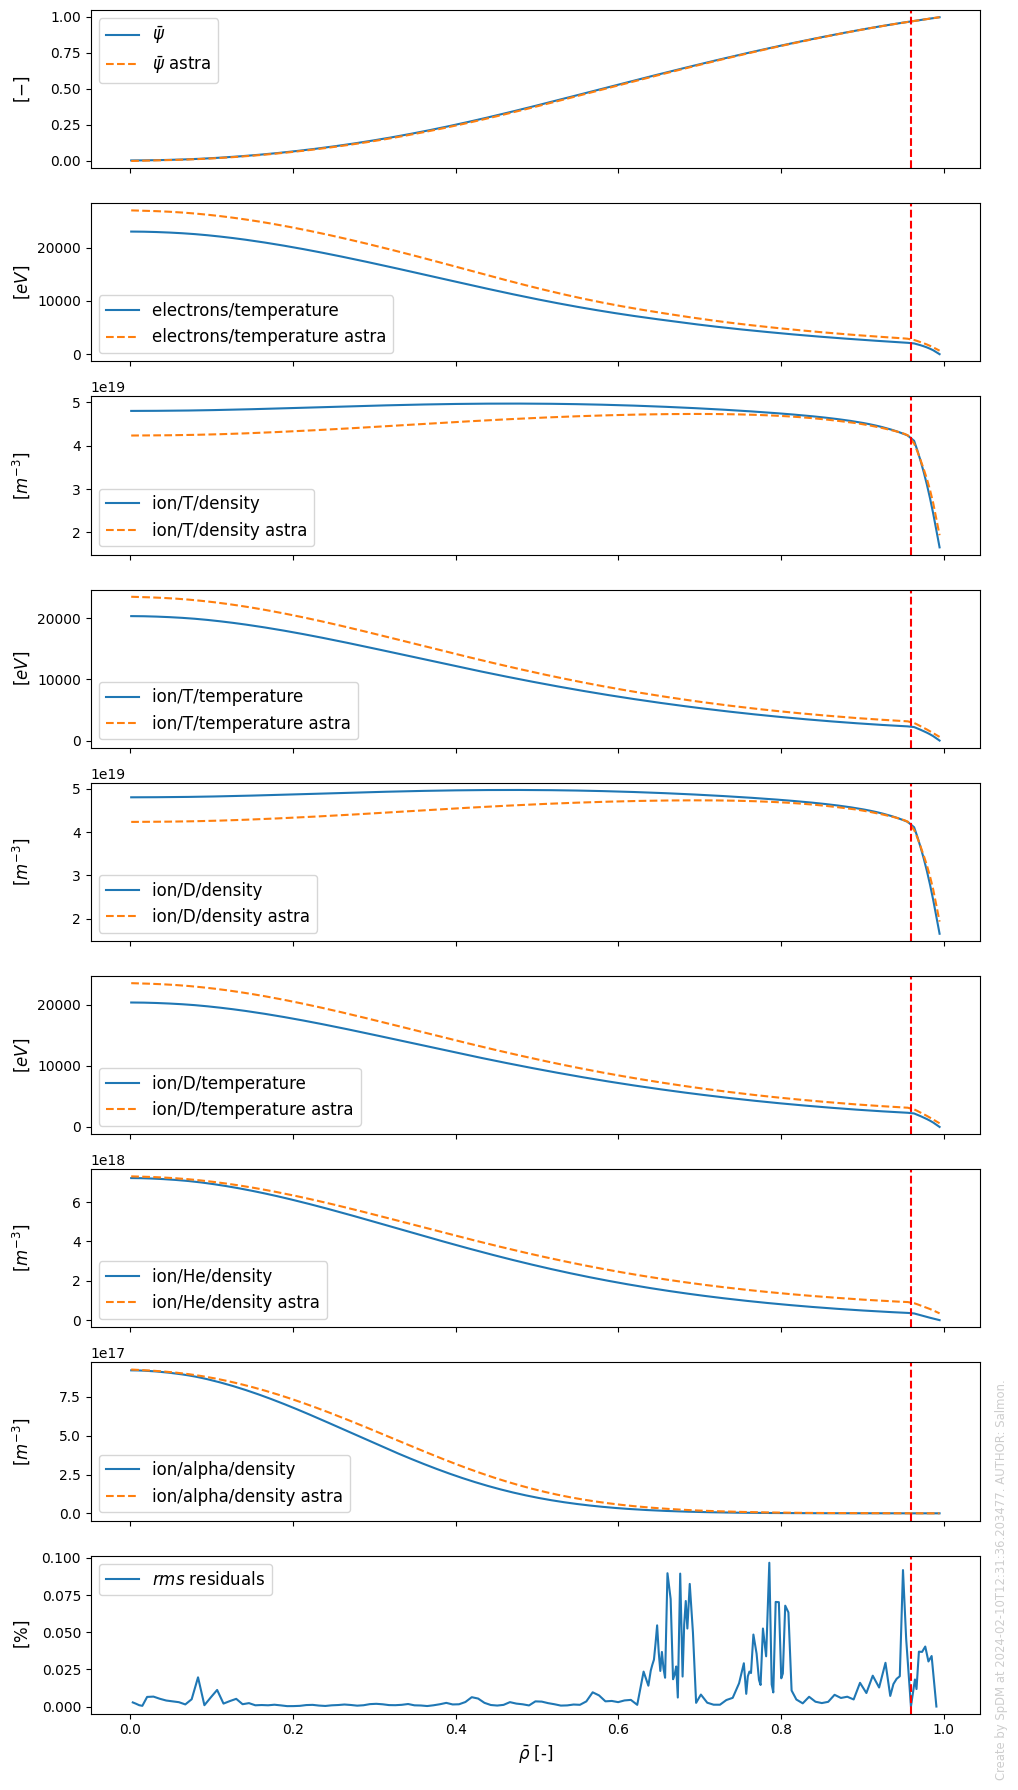

In [31]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.psi_norm, r"$\bar{\psi}$"),
        (
            Function(
                equilibrium_astra.time_slice.current.profiles_1d.grid.rho_tor_norm[:-1],
                equilibrium_astra.time_slice.current.profiles_1d.grid.psi_norm[:-1],
            ),
            {"label": r"$\bar{\psi}$ astra", "$matplotlib": {"linestyle": "dashed"}},
        ),
    ],
    *[
        [
            (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} "),
            (
                Path(equ.identifier).get(core_profiles_1d_astra, 0),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for equ in solver_1d.equations
        if equ.identifier != "psi_norm"
    ],
    (
        (0.5 * (solver_1d.X[:-1] + solver_1d.X[1:]), solver_1d.rms_residuals * 100),
        {"label": "$rms$ residuals", "y_label": r"[\%]"},
    ),
    vline={"x": 0.96, "color": "r", "linestyle": "--"},
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

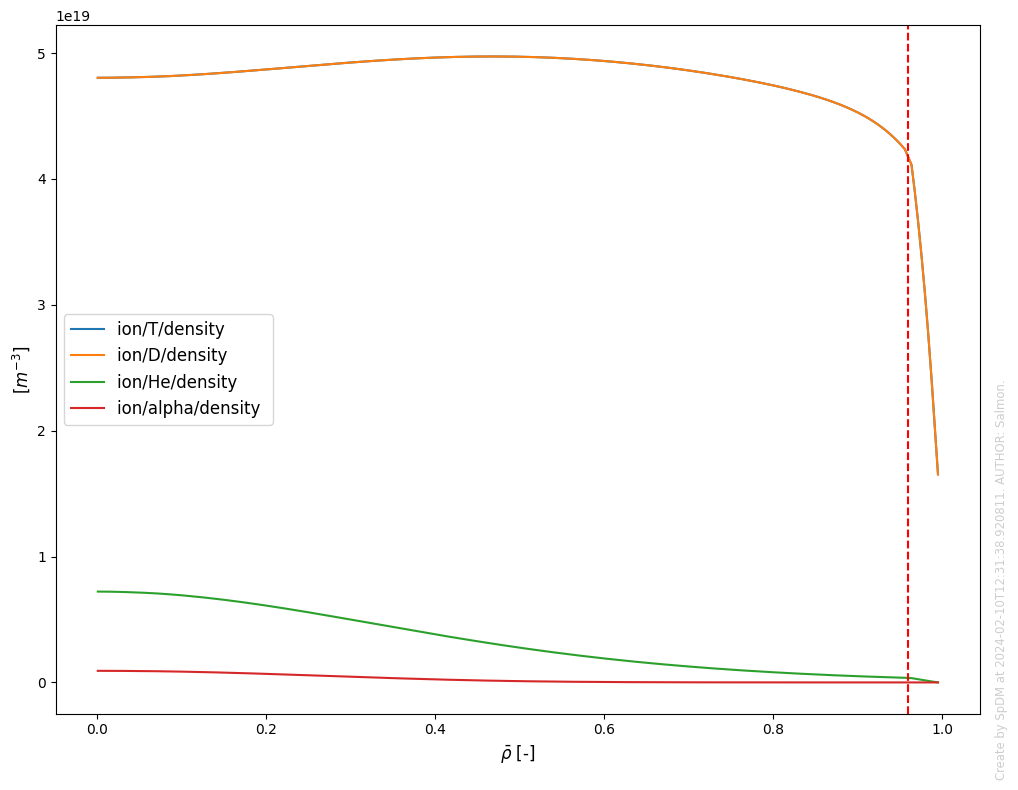

In [32]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} ")
        for equ in solver_1d.equations
        if equ.identifier.endswith("density")
    ],
    vline={"x": 0.96, "color": "r", "linestyle": "--"},
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

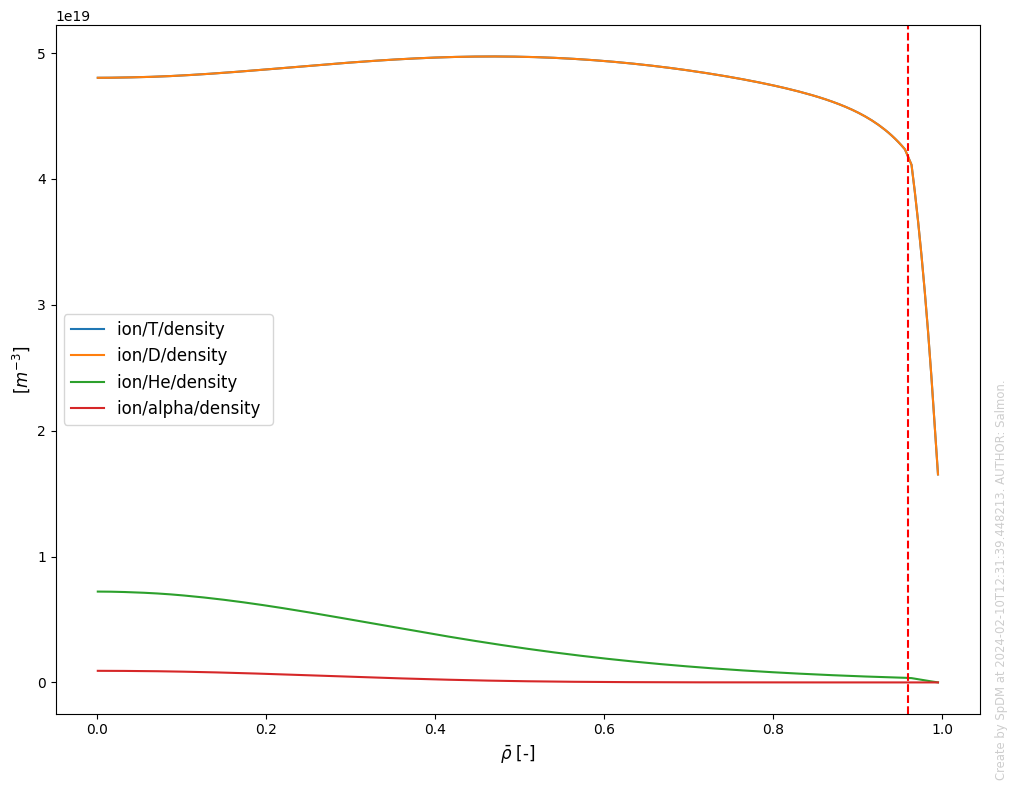

In [33]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} ")
        for equ in solver_1d.equations
        if equ.identifier.endswith("density")
    ],
    vline={"x": 0.96, "color": "r", "linestyle": "--"},
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

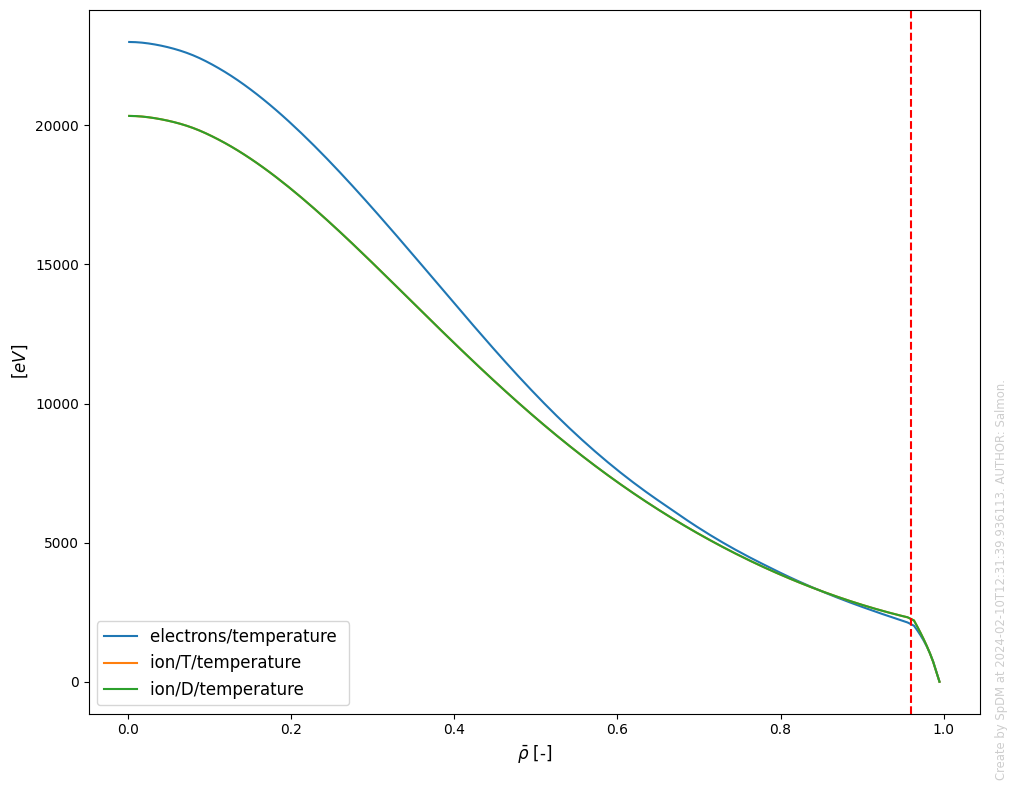

In [34]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} ")
        for equ in solver_1d.equations
        if equ.identifier.endswith("temperature")
    ],
    vline={"x": 0.96, "color": "r", "linestyle": "--"},
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

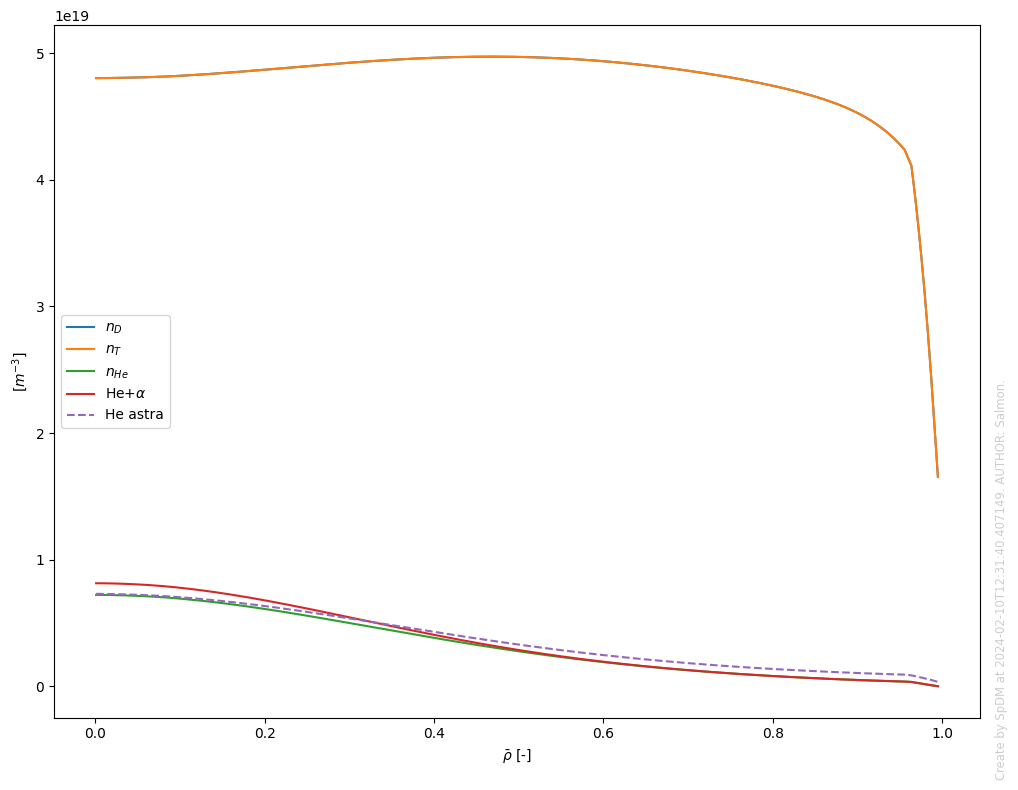

In [35]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        # (core_profiles_1d.ion["alpha"].density, r"$\alpha$"),
        (core_profiles_1d.ion["D"].density, r"n_{D}"),
        (core_profiles_1d.ion["T"].density, r"n_{T}"),
        (core_profiles_1d.ion["He"].density, r"n_{He}"),
        (core_profiles_1d.ion["He"].density + core_profiles_1d.ion["alpha"].density, r"He+$\alpha$"),
        (core_profiles_1d_astra.ion["He"].density, {"label": f"He astra", "$matplotlib": {"linestyle": "dashed"}}),
    ],
    fontsize=10,
    x_label=r"$\bar{\rho}$ [-]",
)

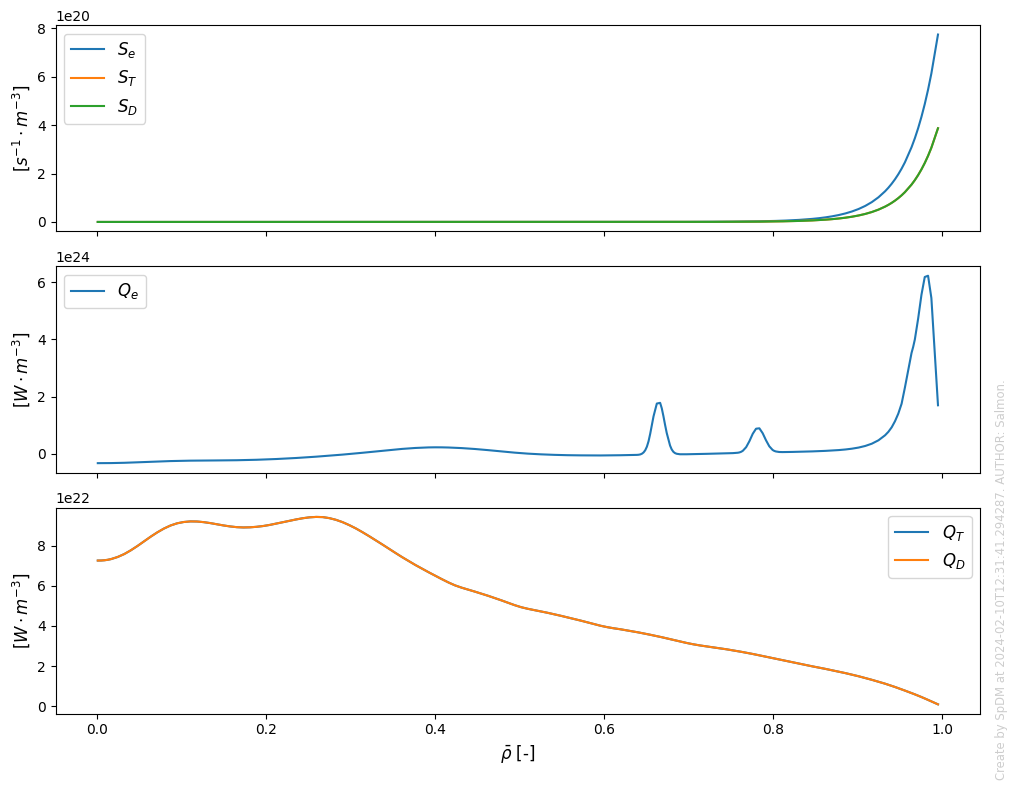

In [36]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")],
    [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

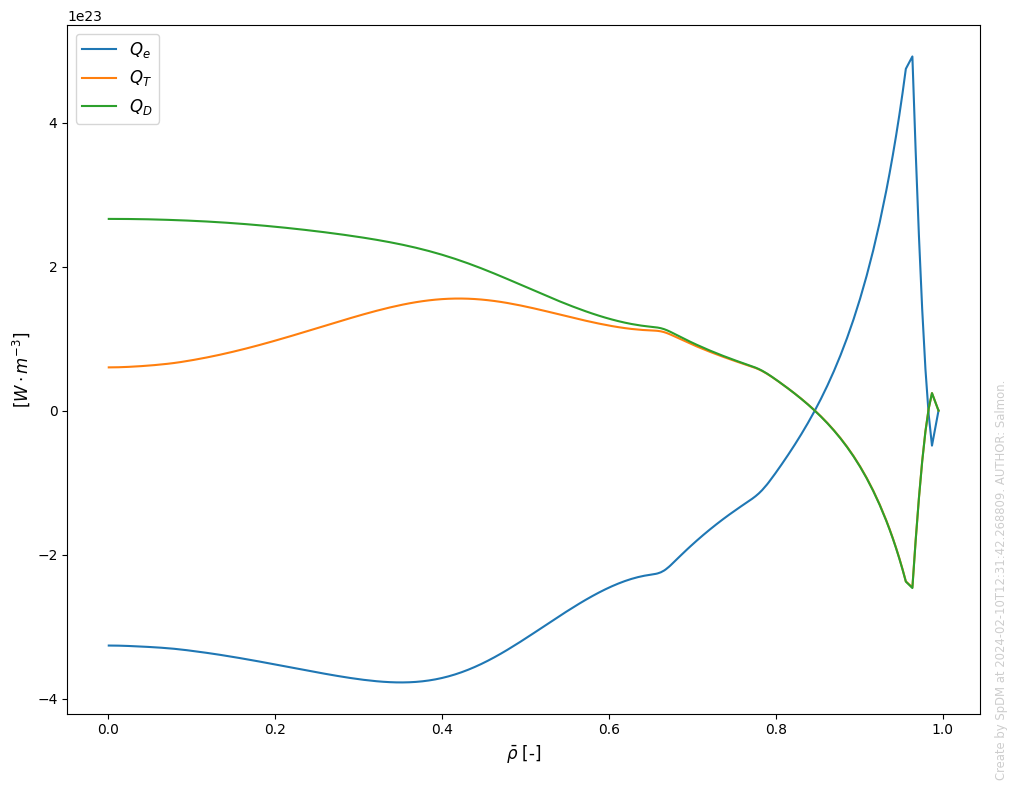

In [37]:
source_1d = tokamak.core_sources.source[1].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    # [
    #     # (core_profiles_1d.electrons.temperature, r"$T_{e}$"),
    #     *[(ion.temperature, rf"$T_{{{ion.label}}}$") for ion in core_profiles_1d.ion],
    # ],  # [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")] + [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

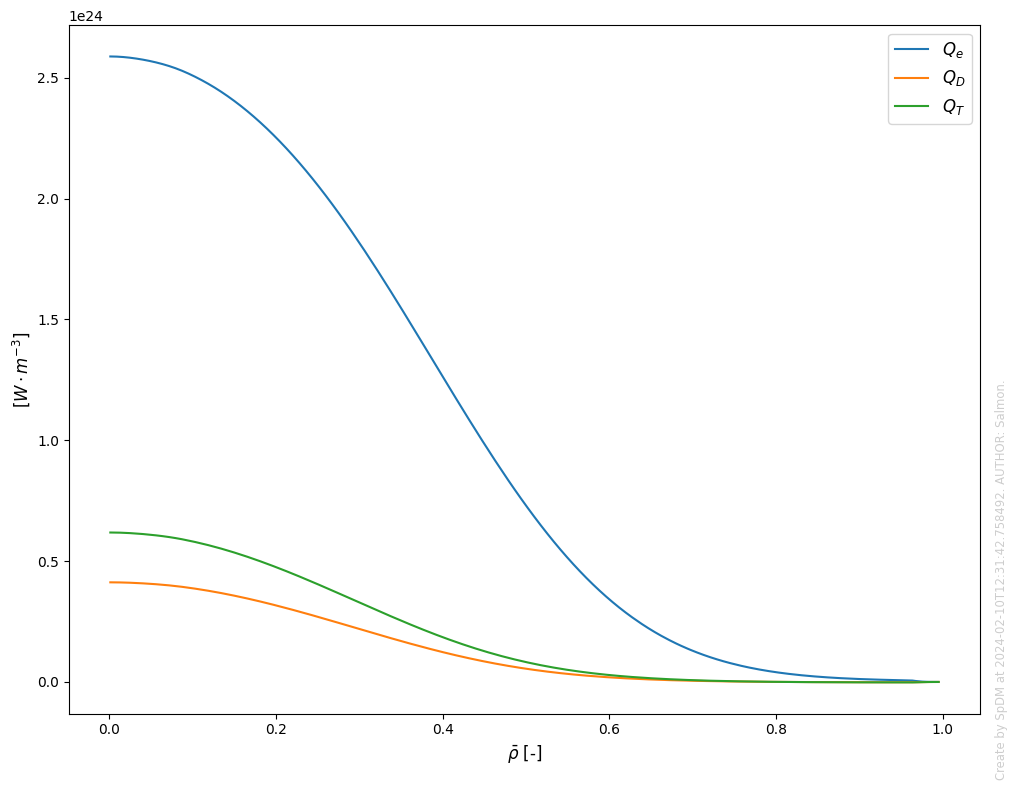

In [38]:
source_1d = tokamak.core_sources.source[2].time_slice.current.profiles_1d

fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    # astra_rho_tor_norm,
    [
        (source_1d.electrons.energy, r"$Q_{e}$"),
        # *[(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
        # (
        #     Function(astra_rho_tor_norm, astra_profiles["Pdte"].values * 1.0e6 / scipy.constants.electron_volt),
        #     {"label": r"$Q_{dte}$", "$matplotlib": {"linestyle": "-", "marker": "."}},
        # ),
        # (
        #     Function(astra_rho_tor_norm, astra_profiles["Pdti"].values * 1.0e6 / scipy.constants.electron_volt),
        #     r"$Q_{dti}$ astra",
        # ),
        # (
        #     Function(astra_rho_tor_norm, (astra_profiles["Pdt"].values) * 1.0e6 / scipy.constants.electron_volt),
        #     r"$Q_{dt}$ astra total",
        # ),
    ]
    + [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion if ion.label in ["D", "T"]],
    # (
    #     Function(astra_rho_tor_norm, astra_profiles["Pdti"].values * 1.0e6 / scipy.constants.electron_volt/2),
    #     {"label": r"$Q_{dti}$", "$matplotlib": {"linestyle": "-", "marker": "."}},
    # ),
    # (
    #     Function(astra_rho_tor_norm, (astra_profiles["Pdt"].values) * 1.0e6 / scipy.constants.electron_volt),
    #     r"$Q_{dt}$ astra total",
    # ),
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

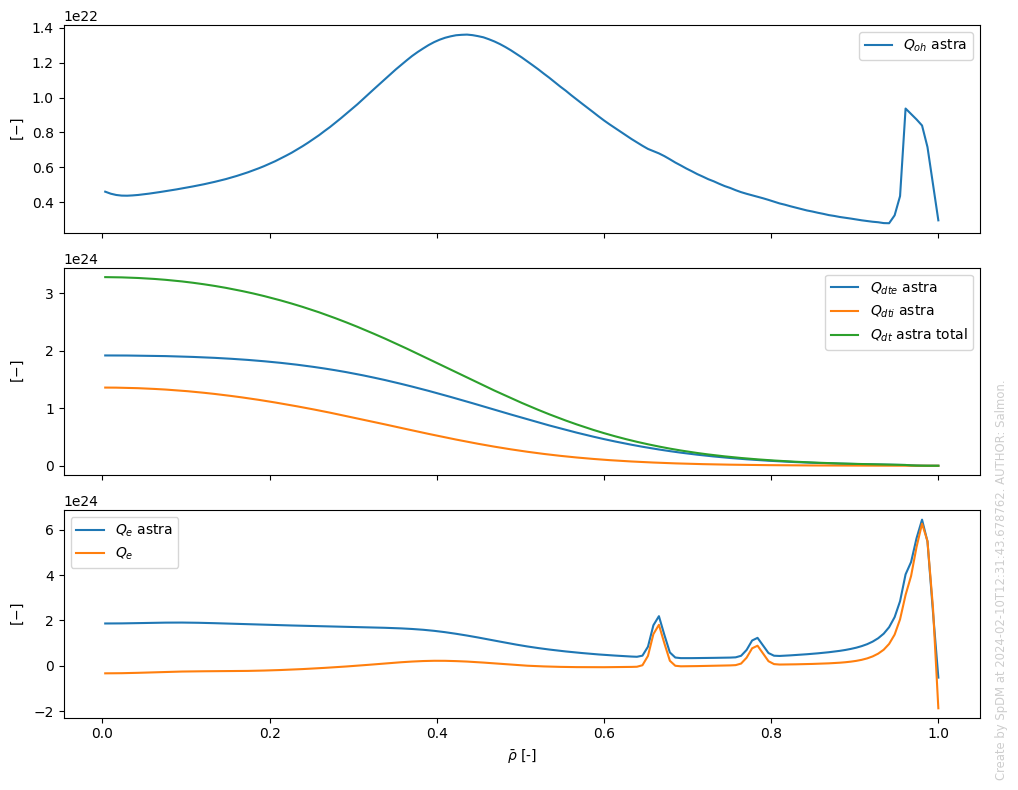

In [39]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d

fig = sp_view.plot(
    # source_1d.grid.rho_tor_norm,
    astra_rho_tor_norm,
    (
        Function(astra_rho_tor_norm, astra_profiles["Poh"].values * 1.0e6 / scipy.constants.electron_volt),
        r"$Q_{oh}$ astra",
    ),
    # [
    #     (tokamak.core_sources.source[1].time_slice.current.profiles_1d.electrons.energy, r"$Q_{e}$"),
    #     *[
    #         (ion.energy, rf"$Q_{{{ion.label}}}$")
    #         for ion in tokamak.core_sources.source[1].time_slice.current.profiles_1d.ion
    #     ],
    # ],
    [
        (
            Function(astra_rho_tor_norm, astra_profiles["Pdte"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dte}$ astra",
        ),
        (
            Function(astra_rho_tor_norm, astra_profiles["Pdti"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dti}$ astra",
        ),
        (
            Function(astra_rho_tor_norm, (astra_profiles["Pdt"].values) * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dt}$ astra total",
        ),
    ],
    [
        (
            Function(
                astra_rho_tor_norm,
                (
                    astra_profiles["Poh"].values
                    + astra_profiles["Paux"].values
                    # - astra_profiles["Prad"].values
                    - astra_profiles["Pneu"].values
                    - astra_profiles["Peic"].values
                    + astra_profiles["Pdte"].values
                )
                * 1.0e6
                / scipy.constants.electron_volt,
            ),
            r"$Q_{e}$ astra",
        ),
        (source_1d.electrons.energy, r"$Q_{e}$"),
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=10,
)

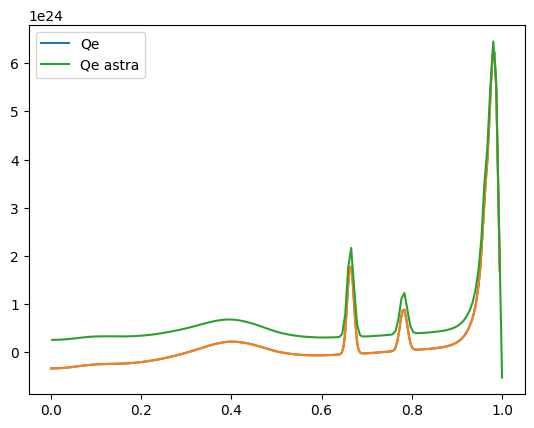

In [40]:
plt.plot(source_1d.grid.rho_tor_norm, source_1d.electrons.energy.__array__(), label="Qe")
plt.plot(source_1d.electrons.energy.domain.dims[0], source_1d.electrons.energy.__array__())
plt.plot(
    astra_rho_tor_norm,
    (
        astra_profiles["Poh"].values
        + astra_profiles["Paux"].values
        # - astra_profiles["Prad"].values
        - astra_profiles["Pneu"].values
        # - astra_profiles["Peic"].values
        # + astra_profiles["Pdte"].values
    )
    * 1.0e6
    / scipy.constants.electron_volt,
    label="Qe astra",
)
plt.legend()

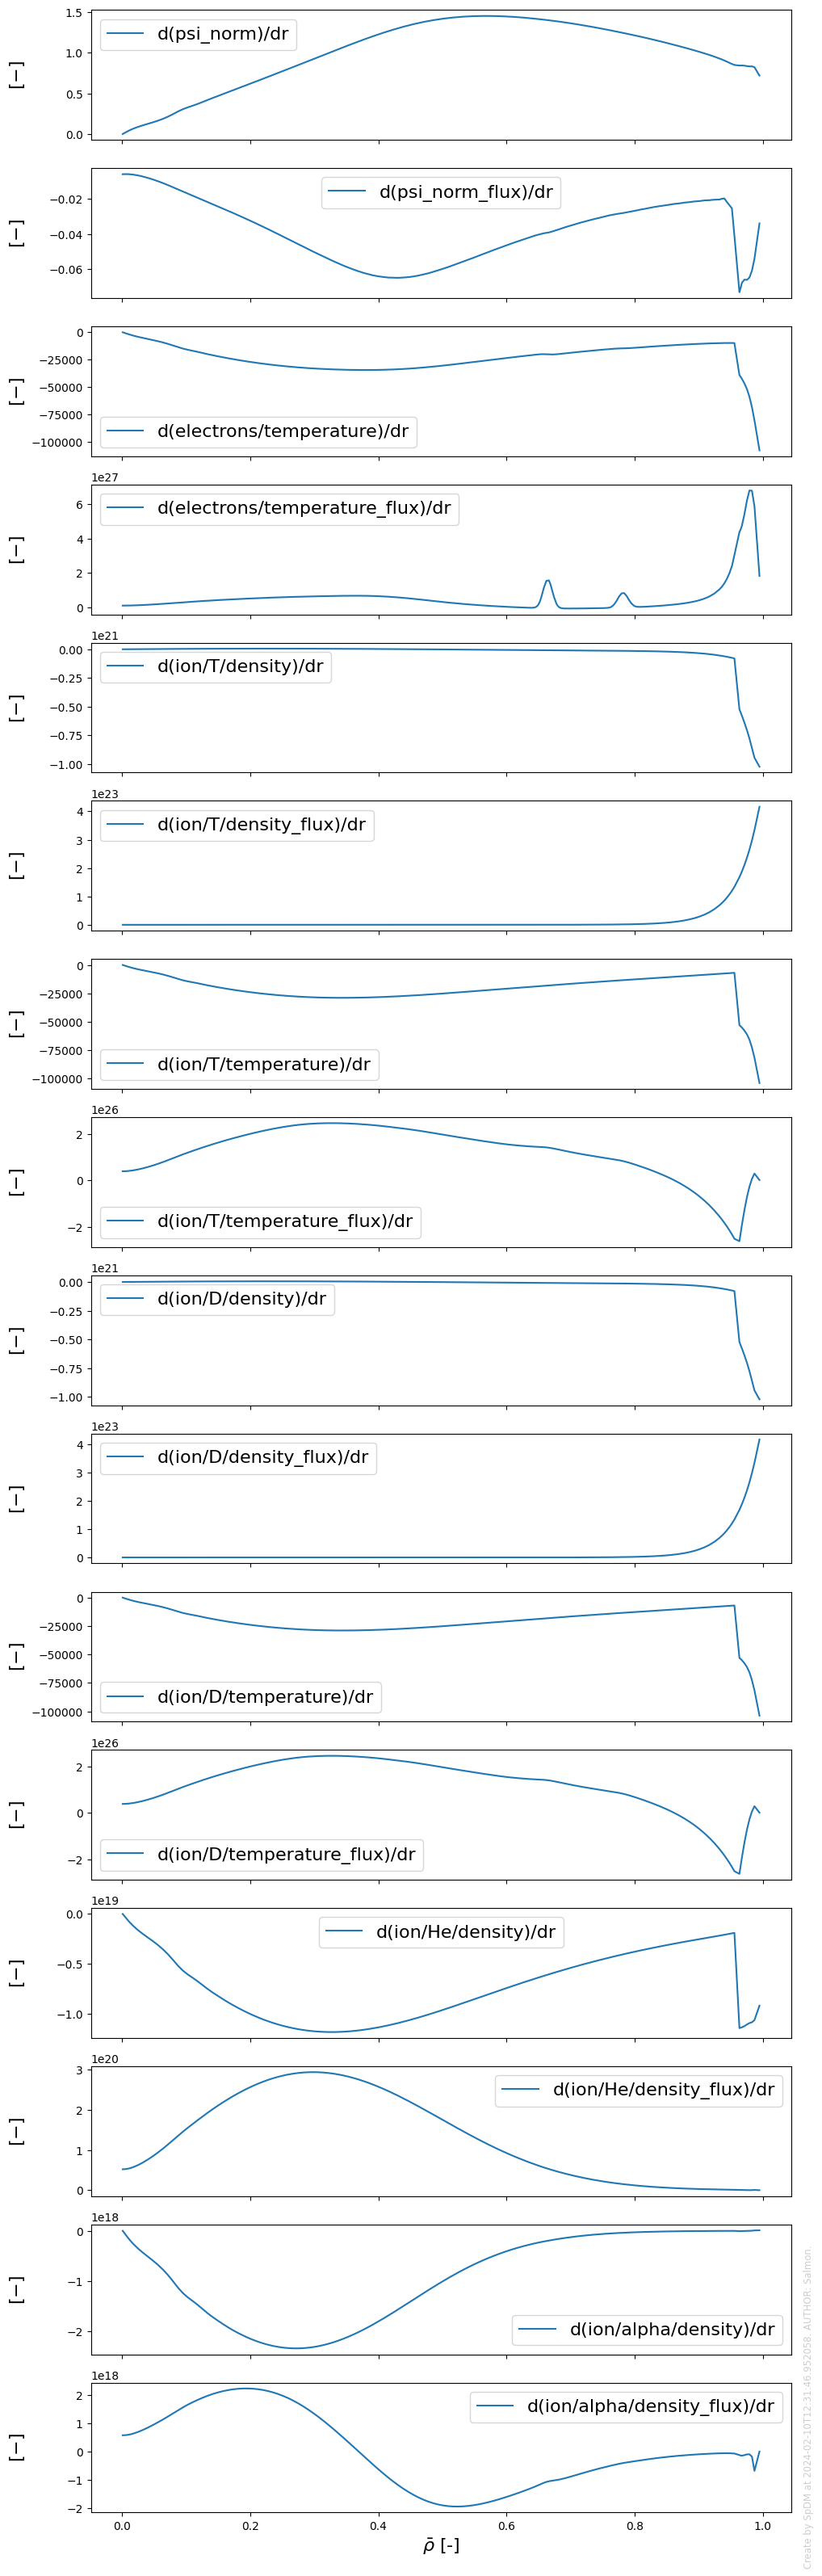

In [41]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                # (solver_1d.Y0[2 * idx], f"d({equ.identifier})/dr"),
                # (solver_1d.Y0[2 * idx + 1], f"d({equ.identifier}_flux)/dr"),
                (equ.d_dr, f"d({equ.identifier})/dr"),
                (equ.dflux_dr, f"d({equ.identifier}_flux)/dr"),
            ]
            for idx, equ in enumerate(solver_1d.equations)
        ],
        [],
    ),
    x_label=r"$\bar{\rho}$ [-]",
)

In [42]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [
        (source_1d.ion[0].particles, source_1d.ion[0].label),
        (source_1d.ion[2].particles, source_1d.ion[2].label),
    ],
    (
        [
            (source_1d.ion[0].energy, source_1d.ion[0].label),
            (source_1d.ion[2].energy, source_1d.ion[2].label),
        ],
        {"y_label": "Energy"},
    ),
)

RuntimeError: Atom key must be a string, not 2 {'e': {'label': 'e', 'z': -1.0, 'a': 0.0005485799090624057, 'mass': 9.1093837015e-31}, 'electron': 'e', 'electrons': 'e', 'n': {'label': 'n', 'z': 0.0, 'a': 1.0, 'mass': 1.67492749804e-27}, 'p': {'label': 'p', 'z': 1, 'a': 1, 'mass': 1.67262192369e-27}, 'H': {'label': 'H', 'z': 1, 'a': 1, 'mass': 1.67262192369e-27}, 'D': {'label': 'D', 'z': 1.0, 'a': 2.0, 'mass': 3.3435837724e-27}, 'T': {'label': 'T', 'z': 1.0, 'a': 3.0, 'mass': 5.0073567446e-27}, '3He': {'label': '3He', 'z': 2, 'a': 3, 'mass': 5.0064127796e-27}, 'He': {'label': 'He', 'z': 2.0, 'a': 4.0, 'mass': 6.6446573357e-27}, 'alpha': 'He', 'Be': {'label': 'Be', 'z': 4.0, 'a': 9.0}, 'Ar': {'label': 'Ar', 'z': 18.0, 'a': 40.0}}